In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import PIL as Image

%matplotlib inline

In [2]:
import os
os.getcwd()
labels = pd.read_csv('data.csv')
test = pd.read_csv('test.csv')
train_path = 'Cancer\Test'
test_path = 'Cancer\Train'

In [3]:
labels.head()


,Image,Benign
0,C:/Users/DELL/Desktop/Cancer/Train/Benign/0.jpg,1
1,C:/Users/DELL/Desktop/Cancer/Train/Benign/1.jpg,1
2,C:/Users/DELL/Desktop/Cancer/Train/Benign/2.jpg,1
3,C:/Users/DELL/Desktop/Cancer/Train/Benign/3.jpg,1
4,C:/Users/DELL/Desktop/Cancer/Train/Benign/4.jpg,1


In [4]:
labels['Benign'].value_counts()

0    17995
1     7885
Name: Benign, dtype: int64

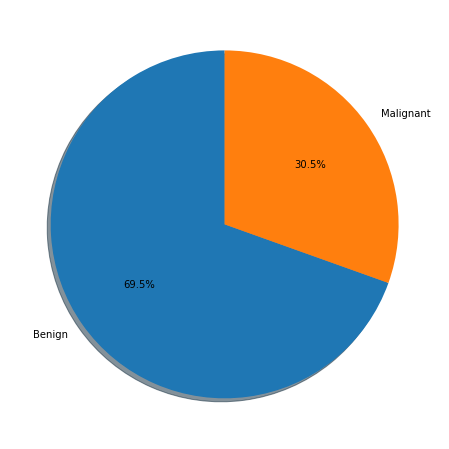

In [5]:
label = 'Benign', 'Malignant'
plt.figure(figsize = (8,8))
plt.pie(labels.groupby('Benign').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

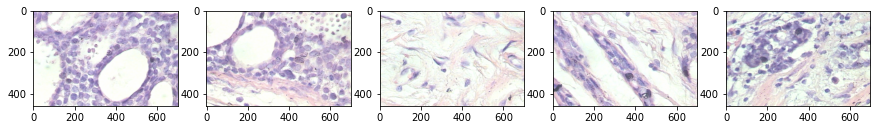

In [6]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['Benign'] == 1]['Image'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

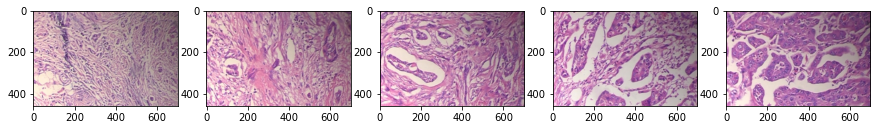

In [7]:

2
3
4
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['Benign'] == 0]['Image'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [9]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [10]:
means = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize([28,28]),                             
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,std),
                                      ])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize([28,28]),                              
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std),
                                    ])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize([28,28]),                            
                                      transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

In [11]:
train, valid_data = train_test_split(labels, stratify=labels.Benign, test_size=0.2)

In [12]:
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(test, test_path, test_transform )

In [13]:
num_epochs = 10
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [17]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)


In [18]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [19]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
n = 10
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for i,(data, target) in enumerate(train_loader):
        if(i>100):
            break
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for it,(data, target) in enumerate(valid_loader):
        if(it>10):
            break
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.071479 	Validation Loss: 0.025680
Epoch: 2 	Training Loss: 0.064043 	Validation Loss: 0.024688
Epoch: 3 	Training Loss: 0.060439 	Validation Loss: 0.023388
Epoch: 4 	Training Loss: 0.061076 	Validation Loss: 0.022469
Epoch: 5 	Training Loss: 0.060990 	Validation Loss: 0.021952
Epoch: 6 	Training Loss: 0.059731 	Validation Loss: 0.021962
Epoch: 7 	Training Loss: 0.058392 	Validation Loss: 0.021347
Epoch: 8 	Training Loss: 0.058540 	Validation Loss: 0.022064
Epoch: 9 	Training Loss: 0.058034 	Validation Loss: 0.022170
Epoch: 10 	Training Loss: 0.056148 	Validation Loss: 0.021542
Wall time: 5min 8s


In [20]:
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for i,(images, labels) in enumerate(test_loader):
        if(i>100):
            break
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 83.08910891089108 %
